In [2]:

import torch
from torch import Tensor
import torch.nn.functional as F
from torchvision import datasets, transforms
from scipy.io import loadmat
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

from typing import Tuple


In [3]:
train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')



In [4]:
first_image = train['X'][:, :, :, 0]
second_image = train['X'][:, :, :, 1]
third_image = train['X'][:, :, :, 2]
first_y = train['y'][0]

# Replacing label 10 to 0
train['y'][train['y'] == 10] = 0
test['y'][test['y'] == 10] = 0
print(f'Image shape is: {first_image.shape}')


Image shape is: (32, 32, 3)


/home/tave/PycharmProjects/pose_estimation_live/venv/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


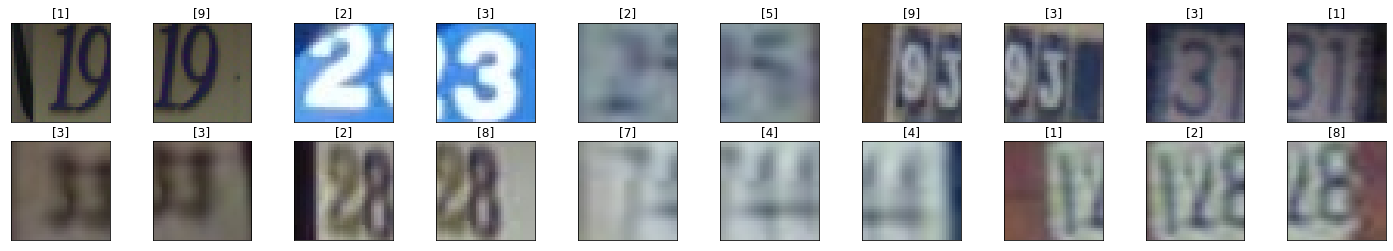

In [5]:
fig = plt.figure(figsize=(25, 4))

for idx in range(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(train['X'][:, :, :, idx])
    ax.set_title(train['y'][idx])

plt.show()


### Preparing dataloader


In [8]:
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5,], [0.5,])])
transform = transforms.Compose([transforms.ToTensor(), ])

svhn_data_train = datasets.SVHN('./', split='train', transform=transform)
svhn_data_test = datasets.SVHN('./', split='test', transform=transform)

data_loader_train = torch.utils.data.DataLoader(svhn_data_train,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=2)

data_loader_test = torch.utils.data.DataLoader(svhn_data_test,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=2)



In [9]:
res = iter(data_loader_train)
for elem in res:
    print(dir(res))
    print(type(res._try_get_data()))
    break



['_IterableDataset_len_called', '__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__next__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_auto_collation', '_base_seed', '_collate_fn', '_data_queue', '_dataset', '_dataset_kind', '_drop_last', '_get_data', '_index_queues', '_index_sampler', '_next_data', '_next_index', '_num_workers', '_num_yielded', '_pin_memory', '_process_data', '_rcvd_idx', '_sampler_iter', '_send_idx', '_shutdown', '_shutdown_worker', '_shutdown_workers', '_task_info', '_tasks_outstanding', '_timeout', '_try_get_data', '_try_put_index', '_worker_init_fn', '_worker_pids_set', '_worker_queue_idx_cycle', '_worker_result_queue', '_workers', '_workers_done_event', '_workers_

### Convolution Model


In [10]:
class ConvClassifier(torch.nn.Module):
    """CNN Class"""
    def __init__(self):
        super().__init__()
        self.conv_1 = torch.nn.Conv2d(3, 6, 5, stride=1, padding=2)  # convolution layer. 1 arg is a number of input channels 2 arg - is the number of output channels 3 -arg - kernel size 4 - stride
        self.conv_2 = torch.nn.Conv2d(6, 12, 3, stride=1, padding=1)
        self.conv_3 = torch.nn.Conv2d(12, 24, 3, stride=1, padding=1) # convolution layer. 1 arg is a number of input channels 2 arg - is the number of output channels 3 -arg - kernel size 4 - stride
        self.fc1 = torch.nn.Linear(4*4*24, 10)  # 50 images 4 by 4 pixels
        # self.fc2 = nn.Linear(500, 10)
        # self.dropout_1 = nn.Dropout(0.5)

    def forward(self, dataset: Tensor):
        dataset = F.relu(self.conv_1(dataset))
        dataset = F.max_pool2d(dataset, 2, 2)
        dataset = F.relu(self.conv_2(dataset))
        dataset = F.max_pool2d(dataset, 2, 2)
        dataset = F.relu(self.conv_3(dataset)) # 24
        dataset = F.max_pool2d(dataset, 2, 2) # 4 x 4 x 24 
        dataset = dataset.view(-1, 4*4*24) # must be flattered
        dataset = self.fc1(dataset)
        # dataset = self.dropout_1(dataset)
        # dataset = self.fc2(dataset)
        return dataset



In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Going to run on {device}')


Going to run on cuda:0


In [12]:

def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    # denormalize
#     image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
#     image = image.clip(0, 1)
    return image


In [13]:
model = ConvClassifier().to(device)
model


ConvClassifier(
  (conv_1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv_2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=384, out_features=10, bias=True)
)

In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [16]:

torch.cuda.empty_cache()

epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for i in range(epochs):
    total_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    # iterate for each training batch
    for inputs, labels in data_loader_train:
        # inputs = inputs.view(inputs.shape[0], -1) we dont neet to flatten it - because networks takes in full pictures
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)  # calculates loss using loss function - how far we are away from the right function
        
        optimizer.zero_grad()
        loss.backward()  # calculates derivitive  for all x in inputs
        optimizer.step() # chandes function parameters
        
        _, preds = torch.max(outputs, 1)
        
        total_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    with torch.no_grad():
        for val_inputs, val_labels in data_loader_test:
            # val_inputs = val_inputs.view(val_inputs.shape[0], -1)
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            
            _, val_preds = torch.max(val_outputs, 1)
        
            val_running_loss += val_loss.item()
            val_running_corrects += torch.sum(val_preds == val_labels.data)
        
        
    epoch_loss = total_loss / len(data_loader_train)
    epoch_acc = running_corrects.float()/len(data_loader_train)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    print('training loss: {:.4f}, {:.4f}'.format(epoch_loss, epoch_acc.item()))
    
    val_epoch_loss = val_running_loss / len(data_loader_test)
    val_epoch_acc = val_running_corrects.float()/len(data_loader_test)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('validation loss: {:.4f}, {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))
    print('\n')
    
print('DONE')


training loss: 1.9687, 1.2444
validation loss: 1.3213, 2.3800


training loss: 1.0634, 2.7008
validation loss: 0.8605, 2.9948


training loss: 0.8093, 3.0365
validation loss: 0.7595, 3.1203


training loss: 0.7082, 3.1675
validation loss: 0.7148, 3.1832


training loss: 0.6482, 3.2468
validation loss: 0.6616, 3.2402


training loss: 0.6059, 3.3010
validation loss: 0.6310, 3.2850


training loss: 0.5750, 3.3415
validation loss: 0.6023, 3.3322


training loss: 0.5506, 3.3677
validation loss: 0.5914, 3.3448


training loss: 0.5310, 3.3915
validation loss: 0.5909, 3.3327


training loss: 0.5156, 3.4120
validation loss: 0.5709, 3.3640


training loss: 0.5014, 3.4278
validation loss: 0.5584, 3.3755


training loss: 0.4894, 3.4399
validation loss: 0.5586, 3.3806


training loss: 0.4777, 3.4551
validation loss: 0.5410, 3.3938


training loss: 0.4674, 3.4687
validation loss: 0.5351, 3.4044


training loss: 0.4578, 3.4738
validation loss: 0.5445, 3.3980


DONE


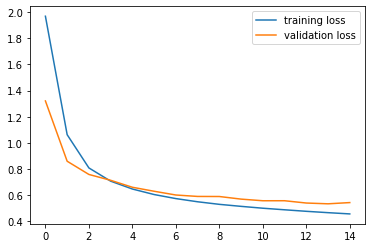

In [17]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()


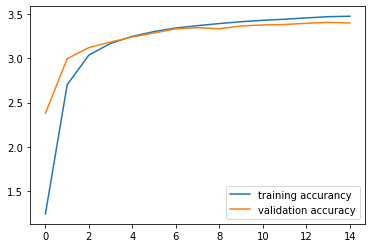

In [18]:
plt.plot(running_corrects_history, label='training accurancy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()


## Saving model for future use


In [20]:

torch.save(model.state_dict(), './model')


## Checking on validation set



predicted: 5. Real: 5
predicted: 2. Real: 2
predicted: 1. Real: 1
predicted: 0. Real: 0
predicted: 6. Real: 6
predicted: 1. Real: 1
predicted: 9. Real: 9
predicted: 1. Real: 1
predicted: 1. Real: 1
predicted: 8. Real: 8
predicted: 9. Real: 3
predicted: 8. Real: 6
predicted: 5. Real: 5
predicted: 1. Real: 1
predicted: 4. Real: 4
predicted: 4. Real: 4
predicted: 1. Real: 1
predicted: 6. Real: 6
predicted: 3. Real: 3
predicted: 4. Real: 4


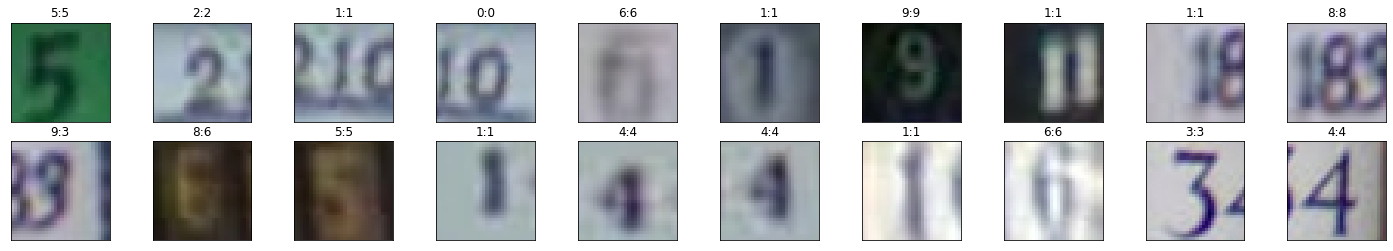

In [42]:
fig = plt.figure(figsize=(25, 4))

for idx in range(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(test['X'][:, :, :, idx])
    image_tensor = test['X'][:, :, :, idx].transpose(2, 0, 1)
    image_tensor = torch.from_numpy(image_tensor).float()
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.to(device)
    
    prediction = model.forward(dataset=image_tensor)
    _, pred = torch.max(prediction, 1)
    print(f'predicted: {pred.item()}. Real: {test["y"][idx].item()}')
    ax.set_title(f'{pred.item()}:{test["y"][idx].item()}')

plt.show()


## Custom data loader

In [ ]:

class SVHNDataset(Dataset):

    def __init__(self, data):
        # Transform data to Torch Tensors
        self.images = torch.tensor(data['X']).permute([3,2,0,1])
        self.labels = torch.tensor(data['y'])
        self.size = self.labels.shape[0]

        # replace label 10 with label 0
        self.labels[self.labels == 10] = 0

        # convert to float and normalize images to 0..1 range
        self.images = self.images.float()
        self.images = self.images / 255
        
    
    def __len__(self):
        return self.size

    def __getitem__(self, index: int) -> Tuple:
        return self.images[index], self.labels[index]
